# Email Spam Detection  - ML Classification

In [75]:
#import necessary libraries
import numpy as np
import pandas as pd
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import string
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.metrics import roc_curve, auc
import re
warnings.filterwarnings('ignore')

In [39]:
#load the data
email_df = pd.read_csv('spam_ham_dataset.csv')
email_df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


## EDA and Preprocessing

In [6]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
email_df["label_num"].value_counts()

0    3672
1    1499
Name: label_num, dtype: int64

In [7]:
email_df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


There is an index and label column which dont have any contribution to the class column label_num. Index is the df index which is unnamed and label is redundant of label_num, therefore it can be dropped

In [41]:
email_df = email_df.drop(['Unnamed: 0', 'label'], axis=1)

In [13]:
email_df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [42]:
#since we have only one for both subject and content, we can seperate it
email_df['subject'] = email_df['text'].str.extract(r'subject:(.*?)\r\n', flags=re.IGNORECASE)
email_df['text'] = email_df['text'].str.replace(r'subject:.*?\r\n', '', flags=re.IGNORECASE)


In [43]:
email_df.head()

,text,label_num,subject
0,this is a follow up to the note i gave you on ...,0,enron methanol ; meter # : 988291
1,( see attached file : hplnol 09 . xls )\r\n- h...,0,"hpl nom for january 9 , 2001"
2,"ho ho ho , we ' re around to that most wonderf...",0,neon retreat
3,abasements darer prudently fortuitous undergon...,1,"photoshop , windows , office . cheap . main t..."
4,this deal is to book the teco pvr revenue . it...,0,re : indian springs


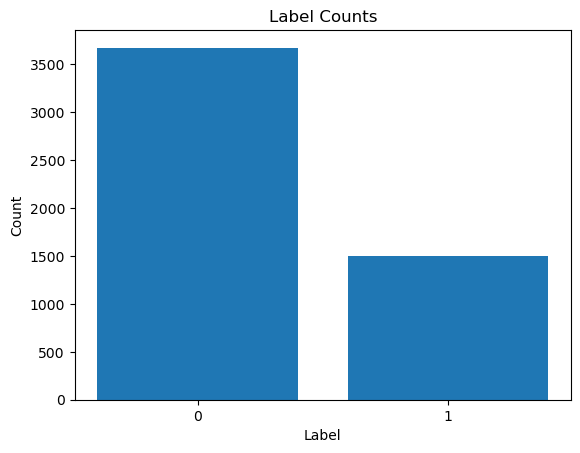

In [37]:
label_counts = email_df['label_num'].value_counts()
plt.bar(['0', '1'], label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.show()

In [45]:
#remove spec charcters
email_df = email_df.applymap(lambda x: re.sub(r'\W+', ' ', str(x)))

In [52]:
#remove common stop and connecting words
stopwords = nltk.corpus.stopwords.words('english')
connecting_words = ['and', 'or', 'but', 'the', 'a','for']
email_df = email_df.applymap(lambda x: ' '.join([word for word in re.split(r'\W+', str(x)) if word.lower() not in stopwords and word.lower() not in connecting_words]))


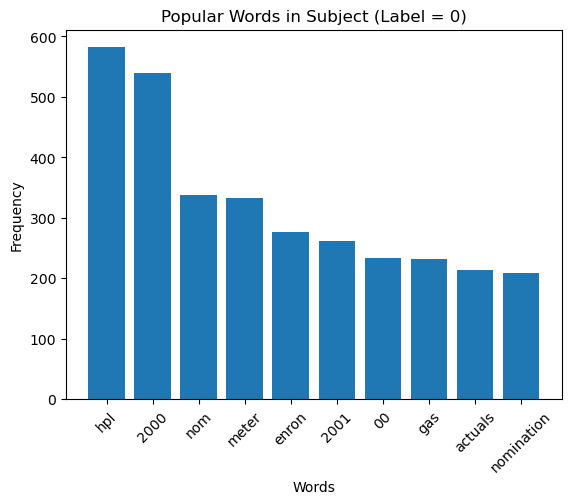

In [53]:
label_0_df = email_df[email_df['label_num'] == '0']
all_subjects = ' '.join(label_0_df['subject'])
subject_words = word_tokenize(all_subjects)
word_freq = FreqDist(subject_words)
if len(word_freq) > 0:
    top_words = word_freq.most_common(10)
    top_words, freq = zip(*top_words)
    plt.bar(top_words, freq)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Popular Words in Subject (Label = 0)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No words found in the subject for Label 0.")

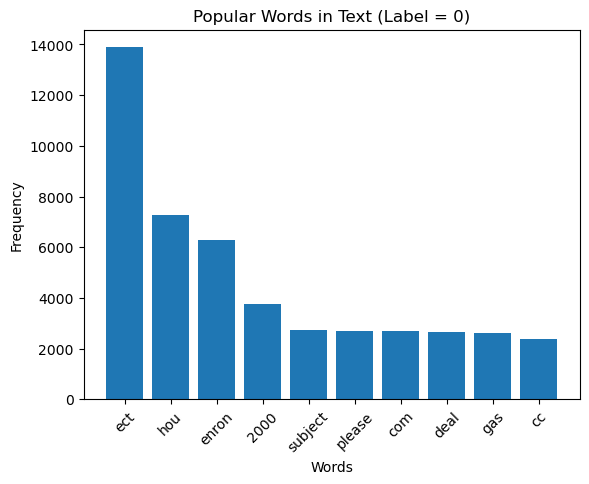

In [54]:
all_text = ' '.join(label_0_df['text'])
text_words = word_tokenize(all_text)
word_freq = FreqDist(text_words)
if len(word_freq) > 0:
    top_words = word_freq.most_common(10)
    top_words, freq = zip(*top_words)
    plt.bar(top_words, freq)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Popular Words in Text (Label = 0)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No words found in the Text for Label 0.")

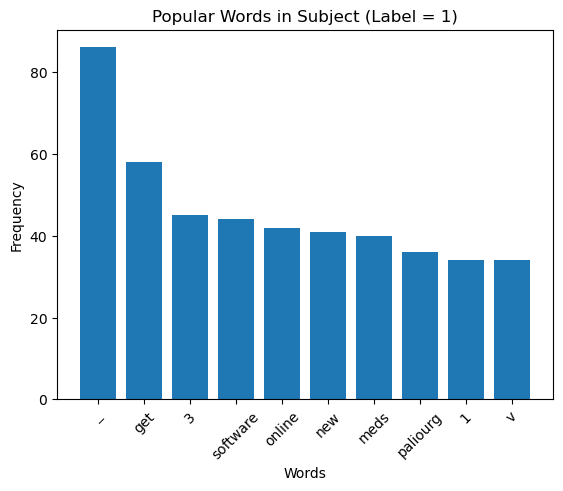

In [55]:
label_1_df = email_df[email_df['label_num'] == '1']
all_subjects = ' '.join(label_1_df['subject'])
subject_words = word_tokenize(all_subjects)
word_freq = FreqDist(subject_words)
if len(word_freq) > 0:
    top_words = word_freq.most_common(10)
    top_words, freq = zip(*top_words)
    plt.bar(top_words, freq)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Popular Words in Subject (Label = 1)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No words found in the subject for Label 1.")

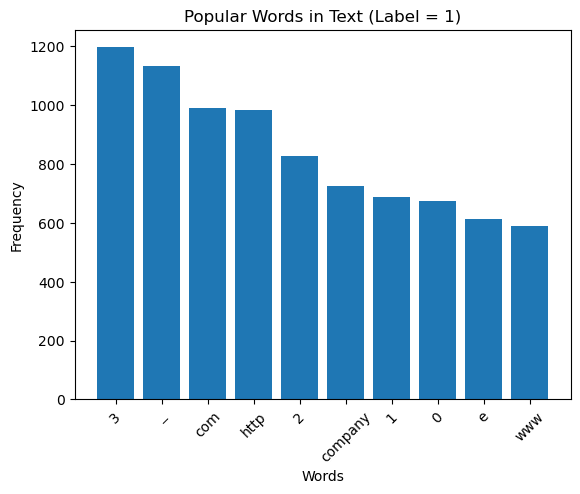

In [57]:
all_text = ' '.join(label_1_df['text'])
text_words = word_tokenize(all_text)
word_freq = FreqDist(text_words)
if len(word_freq) > 0:
    top_words = word_freq.most_common(10)
    top_words, freq = zip(*top_words)
    plt.bar(top_words, freq)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Popular Words in Text (Label = 1)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No words found in the Text for Label 1")

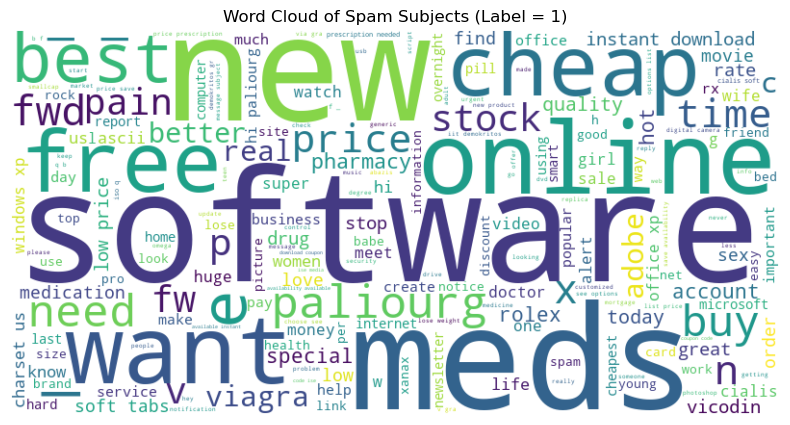

In [60]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_subjects)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Spam Subjects (Label = 1)')
plt.show()

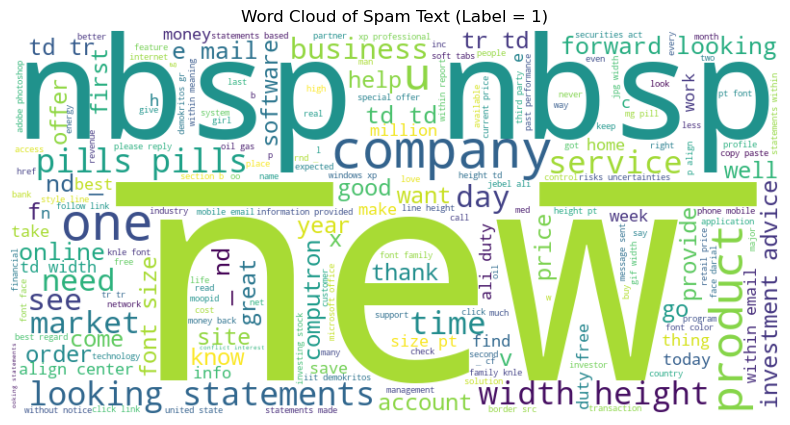

In [61]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Spam Text (Label = 1)')
plt.show()

## Modelling

In [65]:
X_train, X_test , y_train, y_test = train_test_split(email_df['text'], email_df['label_num'] , test_size=0.3)

In [66]:
Vectorizer = CountVectorizer()
count= Vectorizer.fit_transform(X_train.values)

In [68]:
nb = MultinomialNB()
targets = y_train.values
nb.fit(count, targets)
y_pred = nb.predict(Vectorizer.transform(X_test))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1086
           1       0.96      0.91      0.93       466

    accuracy                           0.96      1552
   macro avg       0.96      0.94      0.95      1552
weighted avg       0.96      0.96      0.96      1552



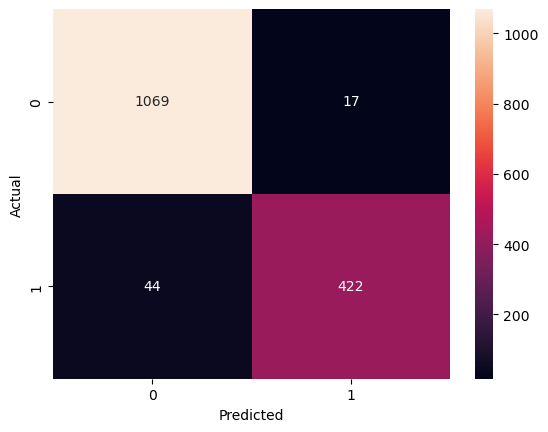

In [73]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
print(classification_report(y_test , y_pred))

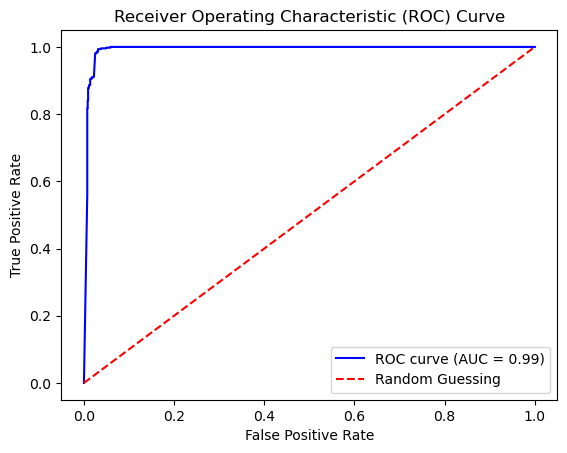

In [77]:
y_test = np.array(y_test, dtype=int)
y_pred_prob = nb.predict_proba(Vectorizer.transform(X_test))[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In conclusion, a Naive Bayes-based email spam detection model was developed, achieving an accuracy of 0.96 and an ROC AUC of 0.99. The model demonstrates strong performance in distinguishing between spam and non-spam emails. The high accuracy score of 0.96 indicates that the model correctly classifies the majority of the emails, with only a small percentage of misclassifications. This showcases the effectiveness of the Naive Bayes algorithm in handling text classification tasks like email spam detection.

Furthermore, the ROC AUC score of 0.99 suggests that the model has excellent discriminatory power. It performs exceptionally well in distinguishing between spam and non-spam emails by minimizing false positive and false negative rates. This indicates that the model's predictions are reliable and consistent.Overall, the developed Naive Bayes-based email spam detection model demonstrates robust performance, offering a highly accurate and efficient solution to identify and filter out unwanted spam emails. This model can be further utilized in email systems or applications to enhance email security and user experience